In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 100

CIFAR-10 Dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 83553348.18it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = (train_dataloader, test_dataloader)

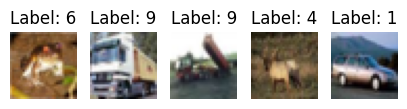

In [7]:
fig, ax = plt.subplots(1, 5,figsize=(5, 2))
for i in range(5):
    image, label = train_dataset[i] 
    image = image.permute(1, 2, 0)
    npimg = image.numpy()
    
    ax[i].imshow(npimg)
    ax[i].axis('off')
    ax[i].set_title(f'Label: {label}')
plt.show()

# Conditional VAE Model

In [8]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        self.num_classes = 10
        self.latent_dim = 100
        self.conv1 = nn.Conv2d(3 + self.num_classes, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.z_mean = nn.Linear(512*4*4, self.latent_dim)
        self.z_log = nn.Linear(512*4*4, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, input, labels):
        bs = input.shape[0]
        
        onehot = torch.zeros(labels.size()[0], self.num_classes).to(input.device)
        onehot = onehot.scatter_(1, labels.view(-1, 1), 1)
        onehot = onehot.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones((bs, self.num_classes, input.shape[2], input.shape[3]), dtype=input.dtype).to(input.device)
        ones = ones * onehot
        
        x = torch.cat((input, ones), dim=1)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log = self.z_log(x)

        eps = torch.randn(bs, self.latent_dim, device=input.device)
        z_val = z_mean + torch.exp(z_log / 2) * eps
        return z_mean, z_log, z_val
    


class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        self.num_classes = 10
        self.latent_dim = 100
        self.fc1 = nn.Linear(self.latent_dim + self.num_classes, 512*4*4)
        self.reshape = nn.Unflatten(1, (512, 4, 4))
        self.conv1 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        self.conv2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 3, 2, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, input, labels):
        
        onehot = torch.zeros(labels.size()[0], self.num_classes).to(input.device)
        onehot = onehot.scatter_(1, labels.view(-1, 1), 1)
        
        input = torch.cat((input, onehot), dim=1)
        
        x = self.relu(self.fc1(input))
        x = self.reshape(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        decoded = self.sigmoid(self.conv4(x))
        return decoded
    



class VAEAutoEncoder(nn.Module):
        
    def __init__(self):
        super(VAEAutoEncoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def forward(self, input, labels):
        z_mean, z_log, z_val = self.encoder(input, labels)
        decoded = self.decoder(z_val, labels)
        return decoded, z_mean, z_log, z_val

In [9]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (conv1): Conv2d(13, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (z_mean): Linear(in_features=8192, out_features=100, bias=True)
      (z_log): Linear(in_features=8192, out_features=100, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (fc1): Linear(in_features=110, out_features=8192, bias=True)
      (reshape): Unflatten(dim=1, unflattened_size=(512, 4, 4))
      (conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), 

Loss Function :- Reconstruction loss + KL Divergence

In [10]:
def vae_loss(preds, targets, z_mean, z_log, z_val):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds.view(targets.shape[0], -1), targets.view(targets.shape[0], -1)) * 3072
    temp = 1.0 + z_log - torch.square(z_mean) - torch.exp(z_log)
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

Training

In [12]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch  
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs,labels)
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds,z_mean, z_log, z_val = model(imgs,labels)
                
                loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss, 'test loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [31:12<00:00, 18.72s/it, train loss=70.1, test loss=72.8]


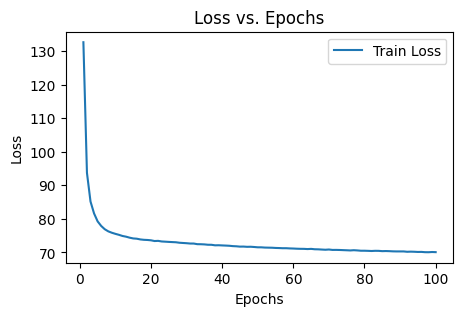

In [13]:
train_vae(dataloaders, model, optimizer, epochs, device)

In [14]:
def plot_images(n, images):
    fig, ax = plt.subplots(1, n, figsize=(12, 3)) 
    for i in range(n):

        if isinstance(images[i], tuple):
            image = images[i][0]  
        else:
            image = images[i] 
            
        image = image.permute(1, 2, 0).numpy()
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

Reconstructing images

tensor([3])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
tensor([8])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
tensor([8])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
tensor([0])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
tensor([6])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])


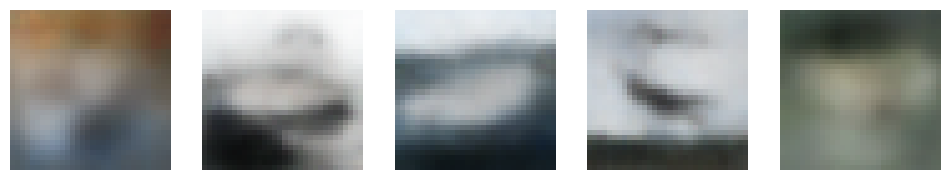

In [15]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
        
    label_tensor = torch.tensor(data[1]).unsqueeze(0)
    print(label_tensor)
    output_imgs = model(data[0].to(device).unsqueeze(0),label_tensor)
    print(output_imgs[0].shape)
    print(output_imgs[3].shape)
    op_img = output_imgs[0].view(3, 32, 32)
    print(op_img.shape)
    predictions.append(op_img.detach().cpu())
plot_images(plots, predictions)

Sampling from Latent Space , conditioned on class

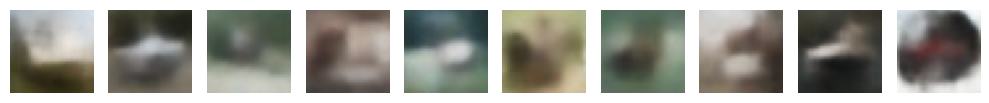

In [16]:
fig, axs = plt.subplots(1, 10, figsize=(10, 5))
for i in range(10):
    rand = torch.randn(1, 100).to(device)
    labels = torch.tensor(i).unsqueeze(0).to(device)
    chek = model.module.decoder(rand, labels)
    chek = chek.view(3, 32, 32)
    chek = chek.detach().cpu()
    
    col = i
    img = chek.permute(1, 2, 0).numpy()
    axs[col].imshow(img)
    axs[col].axis('off')
plt.tight_layout()
plt.show()

# Conditional image generation, conditioned on class labels, sampling from the latent space

Class Label: Airplane


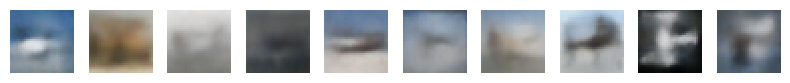

Class Label: Automobile


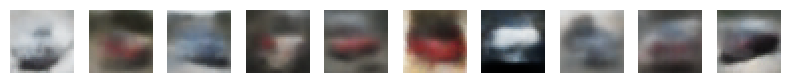

Class Label: Bird


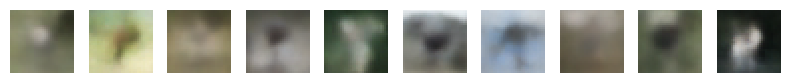

Class Label: Cat


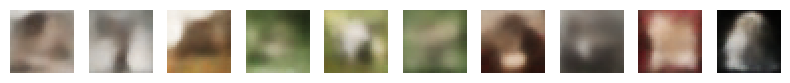

Class Label: Deer


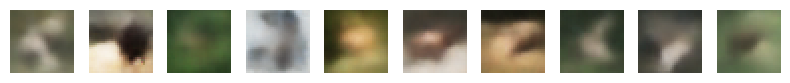

Class Label: Dog


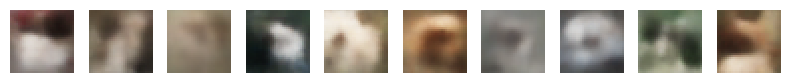

Class Label: Frog


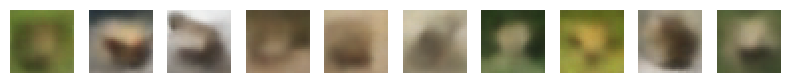

Class Label: Horse


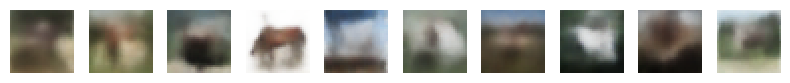

Class Label: Ship


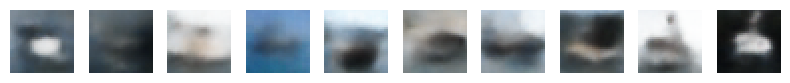

Class Label: Truck


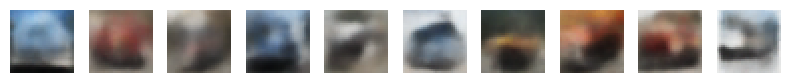

In [17]:
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for j in range(10): 
    fig, axs = plt.subplots(1, 10, figsize=(8, 4))
    for i in range(10):
        rand = torch.randn(1, 100).to(device)
        labels = torch.tensor(j).unsqueeze(0).to(device)
        chek = model.module.decoder(rand, labels)  
        chek = chek.view(3, 32, 32)
        chek = chek.detach().cpu()
        image = chek.permute(1, 2, 0).numpy()
    
        col = i
    
        axs[col].imshow(image)
        axs[col].axis('off')
  
    #print(f'Class Label: {j}')
    print(f'Class Label: {class_labels[j]}')
    plt.tight_layout()
    plt.savefig(f'Class_{class_labels[j]}.png', bbox_inches='tight')
    plt.show()